In [1]:
# import from kaggel dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
#import the data from a github repository

url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(url)

# create a dataframe
df = pd.DataFrame(data)

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8019872249822569

### Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [9]:
# why do we use 0.5 as a threshold? What would happen if we use 0.7? Let´s see what happens with different thresholds
thresholds = np.linspace(0, 1, 21)


In [10]:
scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.505
0.10 0.591
0.15 0.665
0.20 0.709
0.25 0.740
0.30 0.762
0.35 0.770
0.40 0.786
0.45 0.793
0.50 0.802
0.55 0.801
0.60 0.796
0.65 0.784
0.70 0.764
0.75 0.744
0.80 0.732
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [11]:
scores

[0.2739531582682754,
 0.5053229240596168,
 0.5911994322214337,
 0.6650106458481192,
 0.709013484740951,
 0.7395315826827538,
 0.7615330021291696,
 0.7700496806245565,
 0.7856635911994322,
 0.7927608232789212,
 0.8019872249822569,
 0.8005677785663591,
 0.7955997161107168,
 0.7842441447835344,
 0.7643718949609652,
 0.7444996451383961,
 0.7324343506032647,
 0.7260468417317246,
 0.7260468417317246,
 0.7260468417317246,
 0.7260468417317246]

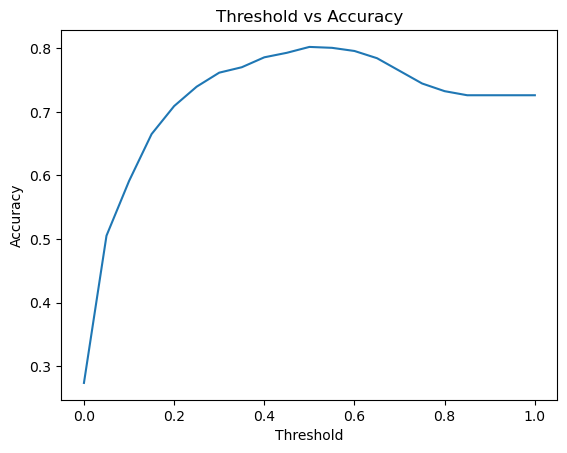

In [12]:
plt.plot(thresholds, scores)
plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()


turn out that 0.5 was the best threshold, but is normal as the regression is optimizing for that

In [13]:
# for creating accuracy we can use sklearn as well
from sklearn.metrics import accuracy_score
thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = accuracy_score(y_val, churn_decision)
    scores.append(score)
    

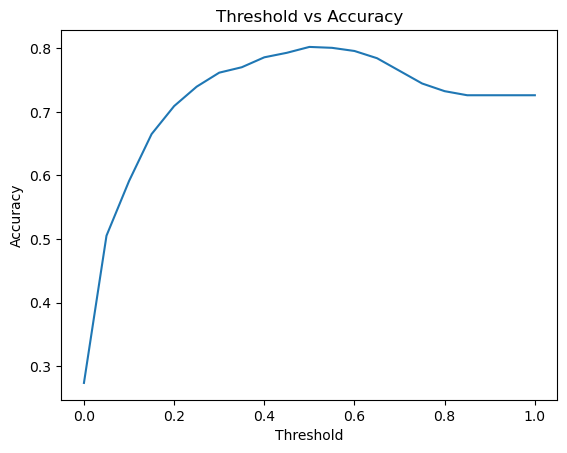

In [14]:
plt.plot(thresholds, scores)
plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()


Interesting:


In [15]:
from collections import Counter # to count the number of elements in a list

Counter(y_pred >= 1)

Counter({False: 1409})

Our model has 80% accuracy and this dummy model that predicts everyone as non churning has 72%.  
Accuracy does not give us the info about how good is our model: if we predict everyone as non churning then we will have the current churn ratio.

Why this happens? has into consideration model imbalances.

### Confusion table

A way of looking to different type of errors and correct decisions.


In [16]:
# implementing the confusion matrix in numpy
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[920, 103],
       [176, 210]])

In [17]:
(confusion_matrix / confusion_matrix.sum()).round(2)


array([[0.65, 0.07],
       [0.12, 0.15]])

Precision: fraction of predicted positive (churn) that are correct


In [18]:
p = tp / (tp + fp)
p

0.670926517571885

there is a 33% of users who will receive the email and that are not going to chirn.

Recall: fraction of 

In [19]:
r = tp / (tp + fn)
r

0.5440414507772021

we fail to identify 46% od churns.

### ROC curves


TRP and FRP

In [20]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [21]:
fpr = fp / (fp + tn)
fpr

0.10068426197458455

In [22]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [23]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [24]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,918,1,105,0.997409,0.897361
2,0.02,384,832,2,191,0.994819,0.813294
3,0.03,383,768,3,255,0.992228,0.750733
4,0.04,382,717,4,306,0.989637,0.700880
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


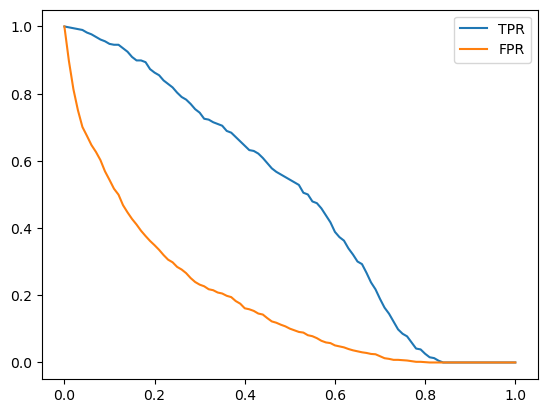

In [25]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

we want the FPR going down and TPR going up.


### Random model

In [26]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [27]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

accuracy with a random model

In [28]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [29]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_model = tpr_fpr_dataframe(y_val, y_pred)


In [30]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


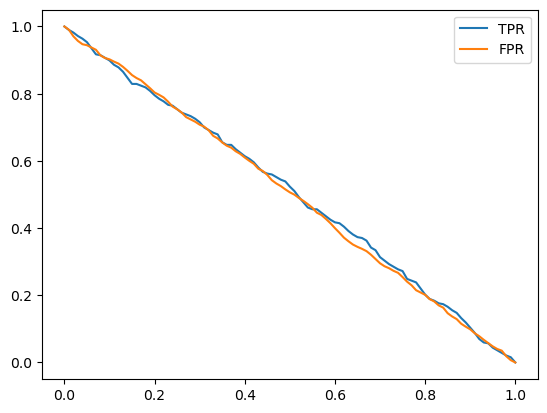

In [31]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model


In [32]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [33]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [35]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [36]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)


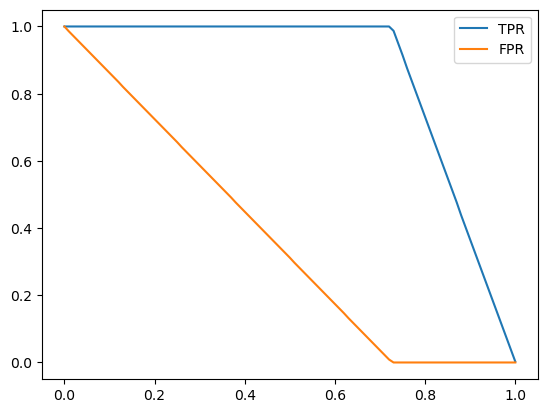

In [37]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Everything together

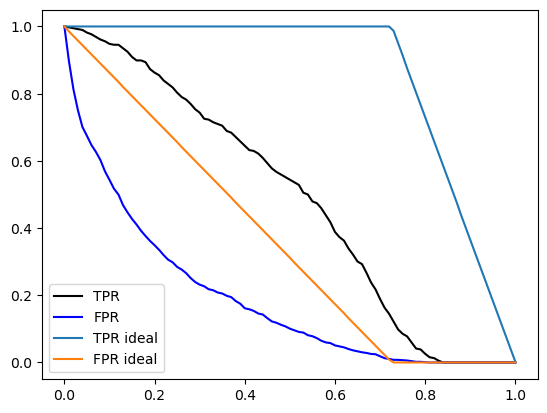

In [38]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

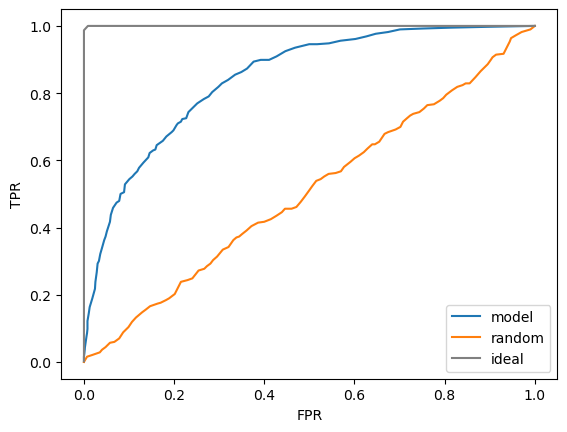

In [39]:
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal', color='grey')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

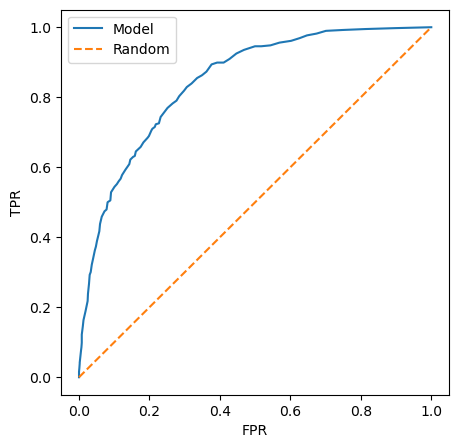

In [40]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--') # random model don´t need to plot the random model, just a line

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### ROC AUC

In [41]:
from sklearn.metrics import auc # area under any curve can be calculated with this function

auc(df_scores.fpr, df_scores.tpr)


0.8438302463039217

In [42]:
#auc(fpr, tpr) # this is the same as the previous one but with the sklearn function


In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.8436377817958964

AUC tell us the probability of a randomly selected positive sample has a higher score than a randomly selected negative sample

In [44]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [45]:
import random

In [46]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1) # random position in the list
    neg_ind = random.randint(0, len(neg) - 1) # random position in the list

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84482

doing same but with numpy using random indexs

In [47]:
n = 100000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84247

### Cross validation

Evaluating the model using different subsets of data  

getting the average prediction and spread within predictions

In [48]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [49]:
dv, model = train(df_train, y_train, C=0.001)

In [50]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [51]:
y_pred = predict(df_val, dv, model)

to do cross validation lets use kfold cross validation

In [52]:
from sklearn.model_selection import KFold

In [53]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [54]:
from tqdm.auto import tqdm # progress bar

In [55]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C=0.01 0.840 +- 0.009


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C=0.1 0.842 +- 0.007


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C=0.5 0.842 +- 0.007


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C=1 0.842 +- 0.007


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C=5 0.842 +- 0.007


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C=10 0.842 +- 0.007


In [ ]:
scores

[0.8445651576641993,
 0.8451384750364191,
 0.8333774834437085,
 0.8348568299545949,
 0.8516990367418656]

In [ ]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8583950837964618